# Laboratorio 5 - Data Science Universidad del Valle de Guatemala
María Marta Ramírez Gil 21342
Gustavo Andrés Gonzalez 21438 

------------------------------------------------------------------------------

Importaciones  

In [47]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import emoji
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

cargar la data

In [4]:
data = pd.read_csv('train.csv')

# EDA

In [9]:
# Mostrar las primeras filas del dataset
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# Chequear si hay valores nulos
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
# Eliminar valores nulos
data = data.dropna()

# Chequear si quedan valores nulos
data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [17]:
# Estadiscas descriptivas del dataset
print("info del dataset:")
data.info()

info del dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5080 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5080 non-null   int64 
 1   keyword   5080 non-null   object
 2   location  5080 non-null   object
 3   text      5080 non-null   object
 4   target    5080 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 238.1+ KB


In [20]:
# Cantidad de columnas
print("Cantidad de columnas:")
print(len(data.columns))
print()

print("Nombre de las columnas:")
print(data.columns)
print()

# Cantidad de filas
print("Cantidad de filas:")
print(data.shape)
print()

# Tipos de datos por columna
print("Tipos de datos por columna:")
data.dtypes

Cantidad de columnas:
5

Nombre de las columnas:
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

Cantidad de filas:
(5080, 5)

Tipos de datos por columna:


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Limpiar y Preprocesamiento de la data

In [45]:
data_copy = data.copy()  # Copia del dataset para mejor manejo de los datos

# Convertir texto a minúsculas
data_copy['text'] = data_copy['text'].str.lower()

# Quitar URL's
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# Quitar puntuación
data_copy['text'] = data_copy['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Quitar stopwords
stop = set(stopwords.words('english'))
data_copy['text'] = data_copy['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Quitar números
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'\d+', '', x))

# Eliminar todas las posibles variantes de 'û'
data_copy['text'] = data_copy['text'].apply(lambda x: re.sub(r'[ûÛ]', '', x))

# Quitar emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

# Aplicar la función a la columna de texto
data_copy['text'] = data_copy['text'].apply(remove_emojis)

# Mostrar las primeras filas del dataset
data_copy.head()

# Guardar el dataset limpio
data_copy.to_csv('train_clean.csv', index=False)    

Se limpian los datos eliminando URLs, puntuación, stopwords, números y emojis.

## Word Frequency Analysis

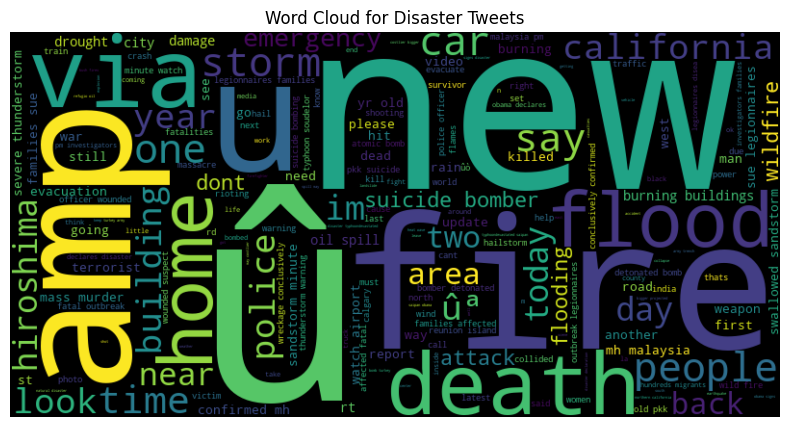

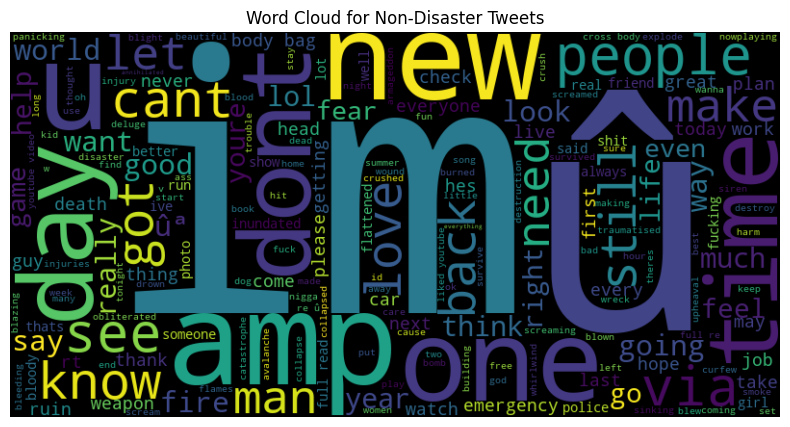

In [46]:
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

# Cantidad de tweets de desastres
disaster_words = ' '.join(disaster_tweets['text'])
non_disaster_words = ' '.join(non_disaster_tweets['text'])

# Generar wordclouds
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(disaster_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Disaster Tweets')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400).generate(non_disaster_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Non-Disaster Tweets')
plt.axis('off')
plt.show()

#### Palabras clave para un mejor modelo de clasificación:

Palabras como `fire`, `flood`, `die`, `emergency`, `killed`, `storm`, `suicide` son indicativas de desastres y deben ser consideradas como clave en el modelo.

Se observa que hay un problema con el caracter û

### Diagramas

In [53]:
# Generar bigramas y trigramas con TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=5000)

# Vectorización del texto con bigramas y trigramas
X = vectorizer.fit_transform(data_copy['text'])

# Definir las etiquetas
y = data_copy['target']

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de clasificación, en este caso, Logistic Regression
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Mostrar algunos bigramas y trigramas más comunes
feature_names = vectorizer.get_feature_names_out()
print("Algunos bigramas y trigramas más comunes:")
for i in range(10):
    print(feature_names[i])

Accuracy: 0.7313
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       580
           1       0.84      0.46      0.60       436

    accuracy                           0.73      1016
   macro avg       0.77      0.70      0.70      1016
weighted avg       0.76      0.73      0.71      1016

Algunos bigramas y trigramas más comunes:
aba woman
aba woman delivers
abandoned aircraft
abandoned aircraft mma
abbswinston zionist
abbswinston zionist terrorist
abc news
ablaze amp
ablaze california
ablaze california alone


Los bigramas como "abandoned aircraft" y "ablaze california" son claros indicadores de desastres, mientras que otros como "abc news" pueden ser menos útiles. Refinar el preprocesamiento para eliminar palabras irrelevantes y utilizar estos n-gramas como características en modelos de clasificación podría mejorar la precisión en la identificación de tweets sobre desastres.

## Entrenamiento del Modelo 1

In [28]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

# Crear el modelo de clasificación de texto con Naive Bayes
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Entrenar el modelo
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Evaluacion del Modelo

Accuracy: 0.8041338582677166
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       580
           1       0.82      0.69      0.75       436

    accuracy                           0.80      1016
   macro avg       0.81      0.79      0.79      1016
weighted avg       0.81      0.80      0.80      1016



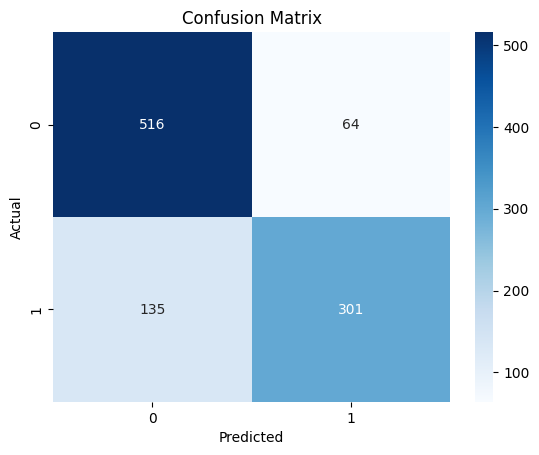

In [29]:
# Predecir los datos de prueba
y_pred = model.predict(X_test)

# Métricas de evaluación
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Funcion para la clasificacion de tweets

In [30]:
def classify_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    return model.predict([text])[0]

### Uso Modelo 1

In [42]:
tweet = "Forest fire near La Ronge Sask. Canada"
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweet(tweet) == 1 else "Not a Disaster")

Tweet: I'm gonna attempt suicide by jumping off a bridge
Classification: Disaster


## Modelo 2

In [51]:
# Vectorización del texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data_copy['text'])

# Definir las etiquetas (0: Not Disaster, 1: Disaster)
y = data_copy['target']

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Support Vector Machine': SVC(kernel='linear')
}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")

# Uso de Logistic Regression para predecir un tweet
def classify_tweetRL(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[ûÛ]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = vectorizer.transform([text])
    return models['Logistic Regression'].predict(text)[0]

# Uso de Naive Bayes para predecir un tweet
def classify_tweetNB(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[ûÛ]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = vectorizer.transform([text])
    return models['Naive Bayes'].predict(text)[0]

# Uso de Random Forest para predecir un tweet
def classify_tweetRF(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[ûÛ]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = vectorizer.transform([text])
    return models['Random Forest'].predict(text)[0] 

# Uso de Support Vector Machine para predecir un tweet
def classify_tweetSVM(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop])
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[ûÛ]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = vectorizer.transform([text])
    return models['Support Vector Machine'].predict(text)[0]

Model: Logistic Regression
Accuracy: 0.8012
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       580
           1       0.83      0.67      0.74       436

    accuracy                           0.80      1016
   macro avg       0.81      0.78      0.79      1016
weighted avg       0.81      0.80      0.80      1016



Model: Naive Bayes
Accuracy: 0.8061
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       580
           1       0.83      0.69      0.75       436

    accuracy                           0.81      1016
   macro avg       0.81      0.79      0.80      1016
weighted avg       0.81      0.81      0.80      1016



Model: Random Forest
Accuracy: 0.7756
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       580
           1       0.79      0.64      0.71       436

    accuracy                           0.78      1016
   mac

Uso

In [52]:
tweet = "Forest fire near La Ronge Sask. Canada"

# Tweet de prueba Linear Regression
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweetRL(tweet) == 1 else "Not a Disaster")

# Tweet de prueba Naive Bayes
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweetNB(tweet) == 1 else "Not a Disaster")

# Tweet de prueba Random Forest
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweetRF(tweet) == 1 else "Not a Disaster")

# Tweet de prueba Support Vector Machine
print("Tweet:", tweet)
print("Classification:", "Disaster" if classify_tweetSVM(tweet) == 1 else "Not a Disaster")


Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster
Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster
Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster
Tweet: Forest fire near La Ronge Sask. Canada
Classification: Disaster


Los modelos fueron puestos a prueba. Todos los modelos tienen un rendimiento muy parecido y similar. Por lo que podemos deicir que la mejora de la precisión no recide en el modelo que se use, si no que en el preprocesamiento de datos y limpieza previa que se realiza.